In [1]:
import os
import pandas as pd
from glob import glob
from PIL import Image
from google.colab import drive

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Mount Google Drive
drive.mount('/content/drive')

# Base directory
base_path = '/content/drive/MyDrive'
sub_path = 'Advanced Machine Learning/skin disease detection fusion model'
full_path = os.path.join(base_path, sub_path)

# Check folders in directory
print("Folders in path:", os.listdir(full_path))

# Step 1: Gather image paths from multiple folders
image_folders = ['images1', 'images2', 'images3']
image_paths = []
for folder in image_folders:
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_paths += glob(os.path.join(full_path, folder, ext))

print(f"Found {len(image_paths)} image files.")

# Step 2: Map image file names to their full paths
image_map = {os.path.basename(path): path for path in image_paths}

# Step 3: Load and prepare metadata
df = pd.read_csv(os.path.join(full_path, "cleaned_metadata.csv"))
df['img_path'] = df['img_id'].map(image_map)
# Removes any rows where img_path is NaN
df = df.dropna(subset=['img_path'])
print(df.shape)

Mounted at /content/drive
Folders in path: ['metadata.csv', '.git', 'images1', '.ipynb_checkpoints', 'images2', 'images3', 'scaler_metadata.pkl', 'cleaned_metadata.csv', 'preprocessing.ipynb', 'only_Encoder.ipynb', 'Full_Autoencoders.ipynb', 'Fine-Tuned Pretrained CNN-based Fusion Model.ipynb', 'Pretrained CNN as Feature Extractor Fusion Model.ipynb']
Found 2298 image files.
(2298, 60)


In [2]:
print(df.columns)

Index(['Unnamed: 0', 'smoke', 'drink', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2',
       'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation',
       'img_id', 'biopsed', 'region_ARM', 'region_BACK', 'region_CHEST',
       'region_EAR', 'region_FACE', 'region_FOOT', 'region_FOREARM',
       'region_HAND', 'region_LIP', 'region_NECK', 'region_NOSE',
       'region_SCALP', 'region_THIGH', 'background_father_BRASIL',
       'background_father_BRAZIL', 'background_father_CZECH',
       'background_father_GERMANY', 'background_father_ISRAEL',
       'background_father_ITALY', 'background_father_NETHERLANDS',
       'background_father_POLAND', 'background_father_POMERANIA',
       'background_father_PORTUGAL', 'background_father_SPAIN',
       'background_father_UNK', 'background_father_Unknown',
       'background_mother_FRANCE', 'background_mother_GE

In [3]:
import timm

# Print out available model names in timm
print(timm.list_models())


['aimv2_1b_patch14_224', 'aimv2_1b_patch14_336', 'aimv2_1b_patch14_448', 'aimv2_3b_patch14_224', 'aimv2_3b_patch14_336', 'aimv2_3b_patch14_448', 'aimv2_huge_patch14_224', 'aimv2_huge_patch14_336', 'aimv2_huge_patch14_448', 'aimv2_large_patch14_224', 'aimv2_large_patch14_336', 'aimv2_large_patch14_448', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_22

First, using pretrain model, we will extract the feature.

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
from torchvision import models
import torch.nn as nn
import timm
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define models
pretrained_models = {
    'ResNet50': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'GoogleNet': models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT),
    'MobileNet': models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT),
    'VGG16': models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT),

    # Vision Transformer (ViT) using timm
    'ViT-B_16': timm.create_model('vit_base_patch16_224', pretrained=True),  # ViT from timm

    # Inception v3 (updated from GoogleNet)
    'InceptionV3': models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT),

    # Transformer-based models using timm
    'DeiT': timm.create_model('deit_base_patch16_224', pretrained=True),
    'CaiT': timm.create_model('cait_s24_224', pretrained=True),
}

# Move models to GPU and set to eval
for name, model in pretrained_models.items():
    # Check if model has the last layer to modify (classifier, fc, etc.)
    if hasattr(model, 'fc'):  # e.g., ResNet, VGG
        model.fc = nn.Identity()
    elif hasattr(model, 'classifier'):  # e.g., ViT, DeiT, MobileNet
        model.classifier = nn.Identity()
    elif hasattr(model, 'head'):  # e.g., DeiT, T2T-ViT, CaiT
        model.head = nn.Identity()
    elif hasattr(model, 'aux_logits'):  # e.g., InceptionV3 (auxiliary classifier)
        model.aux_logits = False




# Extract features
features_dict = {name: [] for name in pretrained_models}


for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features for all models"):
    try:
        img = Image.open(row['img_path']).convert('RGB')
        tensor = transform(img).unsqueeze(0).to(device)  # Move to GPU
        with torch.no_grad():
            for model_name, model in pretrained_models.items():
                output = model(tensor)
                if output.ndim > 2:
                    output = torch.flatten(output, 1)
                # Move back to CPU before numpy
                features_dict[model_name].append(output.squeeze().cpu().numpy())
    except Exception as e:
        for model_name in features_dict:
            features_dict[model_name].append(np.full((1,), np.nan))

# Save features as CSV
for model_name, features in features_dict.items():
    feature_arr = np.vstack(features)
    features_df = pd.DataFrame(feature_arr)
    features_df.index = df.index
    features_df.to_csv(f"{model_name.lower()}_features.csv", index=False)


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 107MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 124MB/s]
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 70.9MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:05<00:00, 21.2MB/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

Extracting features for all models: 100%|██████████| 2298/2298 [12:48<00:00,  2.99it/s]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch.nn as nn

# Simple fusion MLP
class FusionMLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_model(epochs, train_loader, val_loader, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            out = model(batch_X)
            preds = torch.argmax(out, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (weighted): {prec:.4f}")
    print(f"Recall (weighted): {rec:.4f}")
    print(f"F1 (weighted): {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return model, acc, prec, rec, f1, cm


def train_fusion_model(image_feat_path, df, y, epochs=10):
    img_feat = pd.read_csv(image_feat_path)
    meta = df.drop(columns=['img_id', 'diagnostic', 'Unnamed: 0', 'img_path']).astype(np.float32)
    X = np.hstack([img_feat.values, meta.values])
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)


    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)


    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []
    fold_cms = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Split data

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        # Create TensorDatasets
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)
        model = FusionMLP(input_dim=X.shape[1], n_classes=len(np.unique(y)))
        model, acc, prec, rec, f1, cm = train_model(epochs, train_loader, val_loader, model)
        fold_results.append((acc, prec, rec, f1, cm))
        fold_cms.append(cm)

    # Optionally average metrics over folds or return full results
    avg_acc = np.mean([res[0] for res in fold_results])
    avg_prec = np.mean([res[1] for res in fold_results])
    avg_rec = np.mean([res[2] for res in fold_results])
    avg_f1 = np.mean([res[3] for res in fold_results])

    sum_cm = np.sum(fold_cms, axis=0)
    print("Summed Confusion Matrix Across All Folds:")
    print(sum_cm)

    return model, avg_acc, avg_prec, avg_rec, avg_f1, sum_cm, fold_results  # Return all fold results if needed


In [ ]:
results = []

# Define filenames and matching model names
csv_files = [
    "inceptionv3_features.csv",
    "vit-b_16_features.csv",
    "cait_features.csv",
    "deit_features.csv",
    "googlenet_features.csv",
    "mobilenet_features.csv",
    "resnet50_features.csv",
    "vgg16_features.csv",
    "t2t_vit_14_features.csv"  # if you have this one too
]

model_names = [
    "InceptionV3",
    "ViT-B_16",
    "CaiT",
    "DeiT",
    "GoogleNet",
    "MobileNet",
    "ResNet50",
    "VGG16",
    "T2T-ViT"  # must match keys in pretrained_models
]

# Iterate and evaluate
for feat_csv, model_name in zip(csv_files, model_names):
    print(f"\nResults for {model_name}:")

    model, acc, prec, rec, f1, cm, fold_result = train_fusion_model(
        image_feat_path=feat_csv,
        df=df,
        y=df['diagnostic'].values,
        epochs=100
    )

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ConfusionMatrix": cm
    })



Results for InceptionV3:
Accuracy: 0.2891
Precision (weighted): 0.0836
Recall (weighted): 0.2891
F1 (weighted): 0.1297
Confusion Matrix:
[[133   0   0   0   0   0]
 [177   0   0   0   0   0]
 [ 13   0   0   0   0   0]
 [ 50   0   0   0   0   0]
 [ 44   0   0   0   0   0]
 [ 43   0   0   0   0   0]]
Accuracy: 0.3391
Precision (weighted): 0.1150
Recall (weighted): 0.3391
F1 (weighted): 0.1718
Confusion Matrix:
[[156   0   0   0   0   0]
 [157   0   0   0   0   0]
 [ 13   0   0   0   0   0]
 [ 40   0   0   0   0   0]
 [ 44   0   0   0   0   0]
 [ 50   0   0   0   0   0]]
Accuracy: 0.2935
Precision (weighted): 0.0861
Recall (weighted): 0.2935
F1 (weighted): 0.1332
Confusion Matrix:
[[135   0   0   0   0   0]
 [175   0   0   0   0   0]
 [  7   0   0   0   0   0]
 [ 61   0   0   0   0   0]
 [ 39   0   0   0   0   0]
 [ 43   0   0   0   0   0]]
Accuracy: 0.3268
Precision (weighted): 0.1068
Recall (weighted): 0.3268
F1 (weighted): 0.1610
Confusion Matrix:
[[150   0   0   0   0   0]
 [169   0 

FileNotFoundError: [Errno 2] No such file or directory: 't2t_vit_14_features.csv'

In [ ]:
print(results)

<Figure size 1000x600 with 0 Axes>

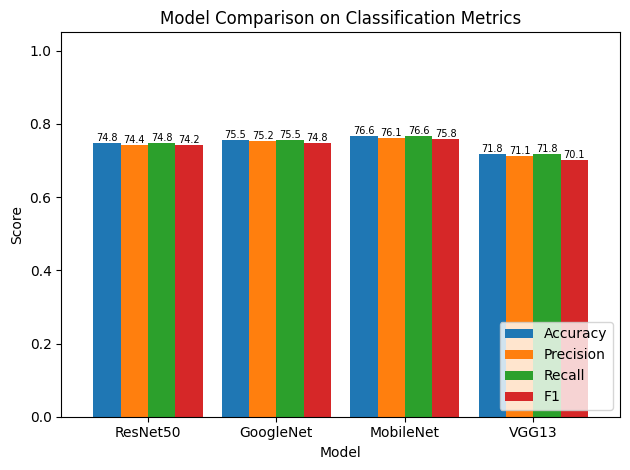

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results = [
    {'Model': 'ResNet50', 'Accuracy': 0.7476, 'Precision': 0.7435, 'Recall': 0.7476, 'F1': 0.7421},
    {'Model': 'GoogleNet', 'Accuracy': 0.7555, 'Precision': 0.7522, 'Recall': 0.7555, 'F1': 0.7480},
    {'Model': 'MobileNet', 'Accuracy': 0.7659, 'Precision': 0.7609, 'Recall': 0.7659, 'F1': 0.7585},
    {'Model': 'VGG13', 'Accuracy': 0.7176, 'Precision': 0.7113, 'Recall': 0.7176, 'F1': 0.7010}
]

df_metrics = pd.DataFrame(results)
df_metrics.set_index("Model", inplace=True)

plt.figure(figsize=(10, 6))
ax = df_metrics[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar', width=0.85)
plt.ylim(0, 1.05)
plt.title("Model Comparison on Classification Metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()

# Add percentage labels to each bar, smaller font and one decimal
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.1f}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=7, rotation=0)

plt.show()


In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

conf_matrix_vgg13 = np.array([
    [575, 119,   1,   7,  18,  10],
    [ 86, 712,   1,  14,  28,   4],
    [  3,  11,  22,  10,   0,   6],
    [  9,  18,   4, 179,   2,  32],
    [ 40, 114,   0,   4,  33,   1],
    [ 52,  17,   2,  32,   4, 128]
])

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_vgg13.astype('float') / conf_matrix_vgg13.sum(axis=1)[:, np.newaxis]

# Define class labels
labels = ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

# Plot confusion matrix heatmap with better color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title("Confusion Matrix - VGG13 (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



In [ ]:
# def calculate_background():
#   # Select N background samples
#   N = 100  # keep this small for KernelExplainer or SHAP Deep

#   background_df = df.sample(n=N, random_state=42)

#   # Compute image features (using pretrained CNN, e.g., ResNet)
#   image_features_background = []
#   meta_features_background = []

#   for _, row in background_df.iterrows():
#       # Load image
#       img = Image.open(row['img_path']).convert("RGB")
#       img_tensor = transform(img).unsqueeze(0).to(device)
#       with torch.no_grad():
#           img_feat = model(img_tensor)
#           if img_feat.ndim > 2:
#               img_feat = torch.flatten(img_feat, 1)
#           image_features_background.append(img_feat.cpu().numpy())

#       # Get metadata
#       meta = row.drop(['img_id', 'img_path', 'diagnostic', 'Unnamed: 0'], errors='ignore').values.astype(np.float32)
#       meta_features_background.append(meta)

#   # Convert to NumPy arrays
#   image_features_background = np.vstack(image_features_background)  # Shape: [N, image_feat_dim]
#   meta_features_background = np.vstack(meta_features_background)    # Shape: [N, meta_feat_dim]

#   return image_features_background, meta_features_background

In [ ]:
pip install torchcam --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

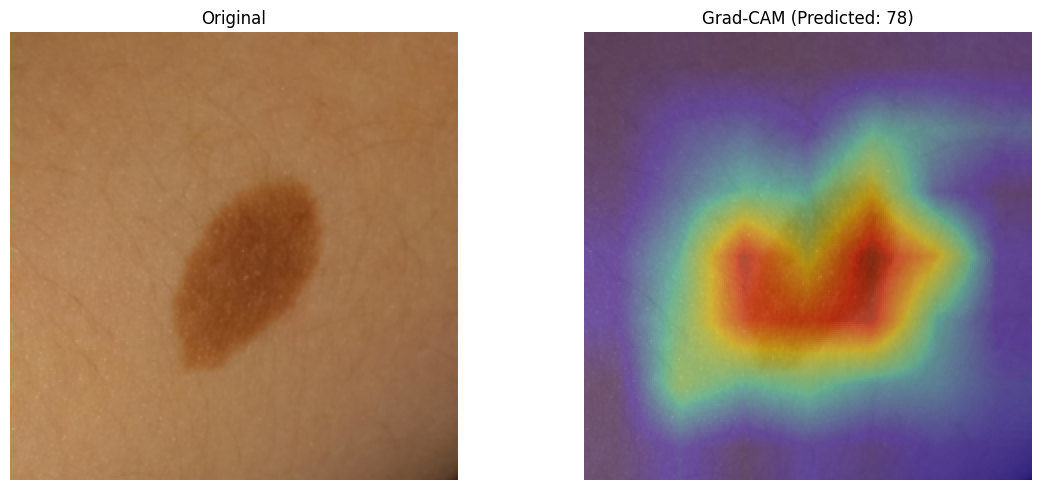


[SHAP] Metadata SHAP values:
[[-6.87004285e-05 -2.09744176e-04 -4.25878767e-04 -2.20541497e-05
   8.80225198e-05  1.54725421e-04]
 [ 3.95560928e-04  9.65424479e-05 -2.23791976e-05 -4.12347639e-04
  -4.61511772e-05  2.05587203e-04]
 [-5.61044953e-06 -9.58299916e-06  9.28329700e-06 -1.51234908e-05
  -8.12065446e-06  1.46000439e-05]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.18072813e-04 -5.77091880e-04 -2.60780158e-04  9.73818242e-04
  -5.11946680e-04 -8.06077209e-04]]


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import torch
import shap
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchcam.methods import GradCAM
from PIL import Image

# --- Settings ---
image_index = 0  # <-- CHANGE THIS INDEX to test different images
image_feat_path = 'resnet50_features.csv'
target_layer = 'layer4'

# --- Load Data ---
row = df.iloc[image_index]
image_path = row['img_path']

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# --- Load image ---
img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

# --- CNN Feature Extractor ---
cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
cnn.eval()
cnn_feature_extractor = torch.nn.Sequential(*list(cnn.children())[:-1])

# --- Grad-CAM ---
cam_extractor = GradCAM(cnn, target_layer=target_layer)
output = cnn(input_tensor)
pred_class = output.argmax().item()
cam = cam_extractor(class_idx=pred_class, scores=output)[0]
cam_resized = F.interpolate(
    cam.unsqueeze(0),
    size=(224, 224),
    mode='bilinear',
    align_corners=False
).squeeze().detach().cpu().numpy()

# --- Plot Grad-CAM ---
image_np = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
image_np = np.clip(image_np, 0, 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_np)
plt.imshow(cam_resized, cmap='jet', alpha=0.4)
plt.title(f"Grad-CAM (Predicted: {pred_class})")
plt.axis('off')
plt.tight_layout()
plt.show()

# --- Load Fusion Model ---
fusion_model = FusionMLP(input_dim=2048 + (df.shape[1] - 4), n_classes=len(df['diagnostic'].unique()))
fusion_model.eval()

# --- Load Image Features ---
image_feat_df = pd.read_csv(image_feat_path)
image_feat = torch.tensor(image_feat_df.iloc[[image_index]].values, dtype=torch.float32).squeeze()

# --- Prepare Metadata ---
meta_tensor = torch.tensor(
    row.drop(['img_id', 'img_path', 'diagnostic', 'Unnamed: 0'], errors='ignore').values.astype(np.float32)
)

# --- SHAP Input ---
combined_input = torch.cat([image_feat, meta_tensor]).unsqueeze(0)

# --- Background (Optional: Use random subset from resnet50_features.csv) ---
background_indices = np.random.choice(len(image_feat_df), 20, replace=False)
meta = df.drop(columns=['img_id', 'diagnostic', 'Unnamed: 0', 'img_path'], errors='ignore').astype(np.float32)
background_feats = torch.tensor(image_feat_df.iloc[background_indices].values, dtype=torch.float32)
background_meta = torch.tensor(meta.iloc[background_indices].values, dtype=torch.float32)
background = torch.cat([background_feats, background_meta], dim=1)

# --- SHAP Explainer ---
explainer = shap.DeepExplainer(fusion_model, background)
shap_values = explainer.shap_values(combined_input)

# --- Display SHAP values for metadata only ---
meta_shap = shap_values[0][:, -meta_tensor.shape[0]:]
print("\n[SHAP] Metadata SHAP values:")
print(meta_shap)

shap.summary_plot(
    meta_shap,
    features=meta_tensor.unsqueeze(0).numpy(),  # Convert to 2D array
    feature_names=[col for col in row.index if col not in ['img_id', 'img_path', 'diagnostic', 'Unnamed: 0']],
    plot_type="bar"
)
